## Download RVL-CDIP from the transformer packages

## download the RVL-CDIP dataset from the google cloud bucket

The labels files list the images and their categories in the following format

path/to/the/image.tif category

where the categories are numbered 0 to 15, in the following order:

0 letter
1 form
2 email
3 handwritten
4 advertisement
5 scientific report
6 scientific publication
7 specification
8 file folder
9 news article
10 budget
11 invoice
12 presentation
13 questionnaire
14 resume
15 memo

the downloaded folders include:

- images/
- labels/
    - test.txt
    - train.txt
    - val.txt
- readme.txt

We will create a toy dataset with the same structure as the original datasets for testing purposes

In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

def make_csv(txt_file, name):
    f = open(txt_file)
    df = {'image_dir':[], "label":[]}
    for line in f:
        line = line.replace('\n', '') # remove new line from the txt files
        line = line.split(" ")
        df['image_dir'].append("data/images/" + line[0])
        df['label'].append(str(line[1]))
    df = pd.DataFrame(df)
    df.to_csv(name, index = False)
    return df

train_df = make_csv("data/labels/train.txt", name = "train.csv")
val_df = make_csv("data/labels/val.txt", name = "val.csv")
test_df = make_csv("data/labels/test.txt", name = "test.csv")
print(train_df.shape,val_df.shape,test_df.shape)

(320000, 2) (40000, 2) (40000, 2)


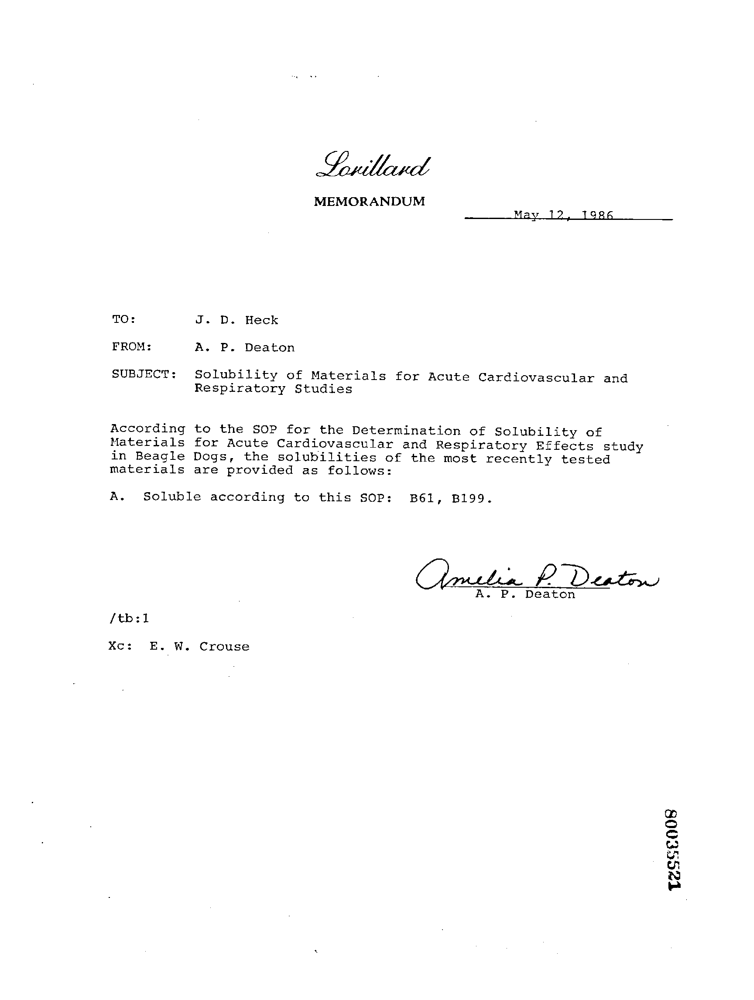

In [23]:
from PIL import Image, ImageDraw, ImageFont
image = Image.open(train_df['image_dir'][0])
image = image.convert("RGB")
image

In [24]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'Seuillard MEMORANDUM. To: J.D. Heck FROM: A. P. Deaton SUBJECT: Solubility of Materials for Acute Cardiovascular and Respiratory Studies According to the SOP for the Determination of Solubility of Materials for Acute Cardiovascular and Respiratory Effects study in Beagle Dogs, the solubilities of the most recently tested materials are provided as follows: A. Soluble according to this Sop: B61, B199. Onihis 2 Destin A. B. Deaton Jeb: Xe: E. W. Crouse TzSS£008'

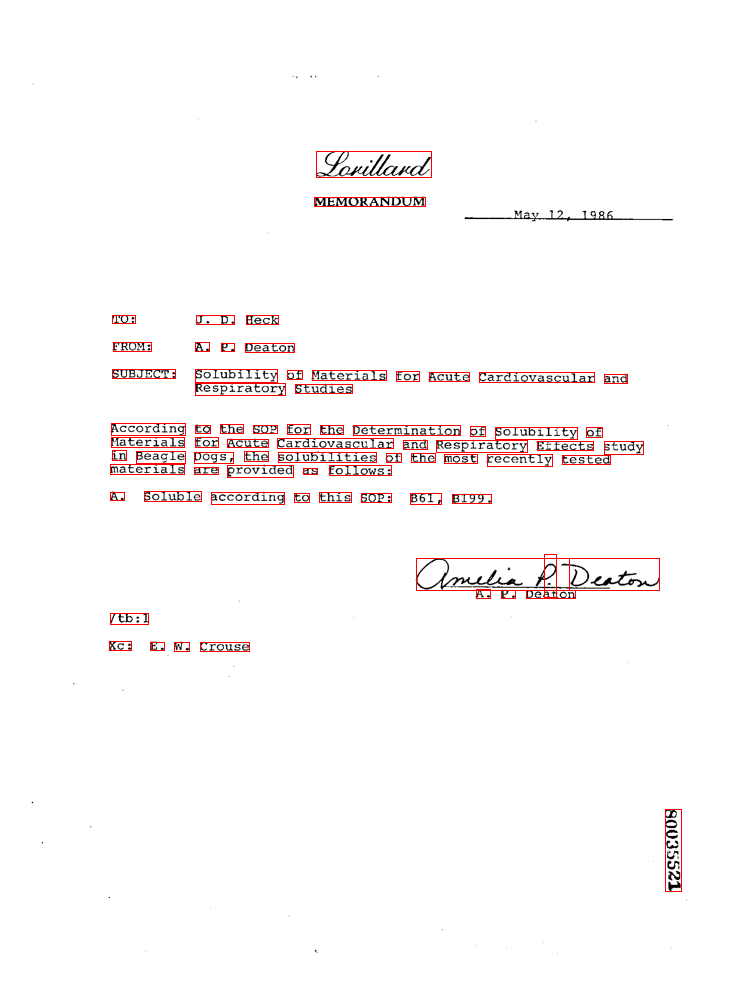

In [25]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box
    actual_boxes.append(actual_box)
draw = ImageDraw.Draw(image, "RGB")
for box in actual_boxes:
    draw.rectangle(box, outline='red')

image

## Preprocess the data using datasets

In [28]:
import pandas as pd
import os
from datasets import Dataset
data_path = "data/images/"

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

def apply_ocr(example):
    # get the image
    image = Image.open(example['image_dir'])

    width, height = image.size

    # apply ocr to the image
    ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
    float_cols = ocr_df.select_dtypes('float').columns
    ocr_df = ocr_df.dropna().reset_index(drop=True)
    ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
    ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
    ocr_df = ocr_df.dropna().reset_index(drop=True)

    # get the words and actual (unnormalized) bounding boxes
    #words = [word for word in ocr_df.text if str(word) != 'nan'])
    words = list(ocr_df.text)
    words = [str(w) for w in words]
    coordinates = ocr_df[['left', 'top', 'width', 'height']]
    actual_boxes = []
    for idx, row in coordinates.iterrows():
        x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
        actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box
        actual_boxes.append(actual_box)

    # normalize the bounding boxes
    boxes = []
    for box in actual_boxes:
        boxes.append(normalize_box(box, width, height))

    # add as extra columns
    assert len(words) == len(boxes)
    example['words'] = words
    example['bbox'] = boxes
    return example

In [78]:
train_temp = train_df.iloc[0:50]
val_temp = val_df.iloc[0:20]
test_temp = test_df.iloc[0:20]

In [79]:
import json
for i, row in train_df.iterrows():
    example = apply_ocr(row)
    file_name = "data/ocr/train/" + example['image_dir'].split('/')[-1]+'.json'
    with open(file_name, 'w') as outfile:
        out = example.to_dict()
        json.dump(out, outfile)

In [80]:
import json
for i, row in val_df.iterrows():
    example = apply_ocr(row)
    file_name = "data/ocr/val/" + example['image_dir'].split('/')[-1]+'.json'
    with open(file_name, 'w') as outfile:
        out = example.to_dict()
        json.dump(out, outfile)

In [81]:
import json
for i, row in test_df.iterrows():
    example = apply_ocr(row)
    file_name = "data/ocr/test/" + example['image_dir'].split('/')[-1]+'.json'
    with open(file_name, 'w') as outfile:
        out = example.to_dict()
        json.dump(out, outfile)

In [82]:
ood_path = "data/ood"
ood_files = os.listdir(ood_path)

In [91]:
ood_images = []
for file_name in ood_files:
    img_dir = ood_path + "/" + file_name
    ood_images.append(img_dir)

In [92]:
ood_images

['data/ood/documentcloud_4_ood__pdf3_documentcloud_00034_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00069_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00060_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00078_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00055_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00027_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00072_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00015_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00058_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00033_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00082_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00016_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00080_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00039_ood.tif',
 'data/ood/documentcloud_4_ood__pdf3_documentcloud_00021_ood.t

In [93]:
ood_data = pd.DataFrame.from_dict({'image_dir':ood_images})

In [97]:
for i, row in ood_data.iterrows():
    example = apply_ocr(row)
    file_name = "data/ocr/ood/" + example['image_dir'].split('/')[-1]+'.json'
    with open(file_name, 'w') as outfile:
        out = example.to_dict()
        json.dump(out, outfile)

In [98]:
train_temp

,image_dir,label
0,data/images/imagesq/q/o/c/qoc54c00/80035521.tif,15
1,data/images/imagese/e/w/c/ewc23d00/513280028.tif,1
2,data/images/imagesw/w/b/t/wbt26e00/2053453161.tif,7
3,data/images/imagesm/m/k/m/mkm05e00/2040792992_...,10
4,data/images/imageso/o/e/x/oex80d00/522787731+-...,3
5,data/images/imagesq/q/v/t/qvt06d00/50525666-56...,14
6,data/images/imagesr/r/l/z/rlz20d00/521107137+-...,11
7,data/images/imagesk/k/n/i/kni98c00/87538356_83...,13
8,data/images/imagesm/m/q/v/mqv03f00/0011846871.tif,0
9,data/images/imagesf/f/o/x/fox75a00/2505168109_...,2


In [107]:
# generate processed data csv
train_dir = []
train_label = []
for i, row in train_temp.iterrows():
    file_name = "data/ocr/train/" + row['image_dir'].split('/')[-1]+'.json'
    train_dir.append(file_name)
    train_label.append(row['label'])

processed_train = pd.DataFrame.from_dict({'image_dir':train_dir,
                                          'label':train_label})
processed_train.to_csv("processed_train.csv",index = False)

In [108]:
val_dir = []
val_label = []
for i, row in val_temp.iterrows():
    file_name = "data/ocr/val/" + row['image_dir'].split('/')[-1]+'.json'
    val_dir.append(file_name)
    val_label.append(row['label'])

processed_val = pd.DataFrame.from_dict({'image_dir':val_dir,
                                          'label':val_label})
processed_val.to_csv("processed_val.csv",index = False)

In [109]:
test_dir = []
test_label = []
for i, row in test_temp.iterrows():
    file_name = "data/ocr/test/" + row['image_dir'].split('/')[-1] + '.json'
    test_dir.append(file_name)
    test_label.append(row['label'])

processed_test = pd.DataFrame.from_dict({'image_dir': test_dir,
                                        'label': test_label})
processed_test.to_csv("processed_test.csv", index=False)

In [113]:
ood_dir = []
for i, row in ood_data.iterrows():
    file_name = "data/ocr/ood/" + row['image_dir'].split('/')[-1] + '.json'
    ood_dir.append(file_name)

processed_ood = pd.DataFrame.from_dict({'image_dir': ood_dir})
processed_ood.to_csv("processed_ood.csv", index=False)

In [119]:
def load_id():
    train_df = pd.read_csv("data/processed_train.csv")
    val_df = pd.read_csv("data/processed_val.csv")
    test_df = pd.read_csv("data/processed_test.csv")
    train_temp = train_df.iloc[0:50]
    val_temp = val_df.iloc[0:20]
    test_temp = test_df.iloc[0:20]

    datasets = {'train': train_temp, 'validation': val_temp, 'test': test_temp}
    return datasets

def load_ood():
    ood_df = pd.read_csv("data/processed_ood.csv")
    datasets = {'test': ood_df}
    return datasets

In [120]:
datasets = load_id()

In [121]:
temp = datasets['train']

,image_dir,label
0,data/ocr/train/80035521.tif.json,15
1,data/ocr/train/513280028.tif.json,1
2,data/ocr/train/2053453161.tif.json,7
3,data/ocr/train/2040792992_2040792994.tif.json,10
4,data/ocr/train/522787731+-7732.tif.json,3
5,data/ocr/train/50525666-5667.tif.json,14
6,data/ocr/train/521107137+-7140.tif.json,11
7,data/ocr/train/87538356_8359.tif.json,13
8,data/ocr/train/0011846871.tif.json,0
9,data/ocr/train/2505168109_8112.tif.json,2


In [140]:
def parse_json(example):
    json_file = example['image_dir']
    with open(json_file, 'r') as file:
        ocr_result = json.load(file)
    return ocr_result

In [141]:
temp_data = Dataset.from_pandas(temp)
updated_temp = temp_data.map(parse_json)

100%|██████████| 50/50 [00:00<00:00, 607.68ex/s]


In [145]:
train_df = pd.read_csv("data/processed_train.csv")
val_df = pd.read_csv("data/processed_val.csv")
test_df = pd.read_csv("data/processed_test.csv")
train_temp = Dataset.from_pandas(train_df.iloc[0:50])
val_temp = Dataset.from_pandas(val_df.iloc[0:20])
test_temp = Dataset.from_pandas(test_df.iloc[0:20])

updated_train = train_temp.map(parse_json)
updated_val = val_temp.map(parse_json)
updated_test = test_temp.map(parse_json)
datasets = {'train': updated_train, 'validation': updated_val, 'test': updated_test}

100%|██████████| 20/20 [00:00<00:00, 1687.61ex/s]


In [163]:
from transformers import LayoutLMTokenizer
import torch
from datasets import Features, Sequence, ClassLabel, Value, Array2D

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def encode_example(example, max_seq_length=512,pad_token_box=[0, 0, 0, 0]):

    words = example['words']
    normalized_word_boxes = example['bbox']

    assert len(words) == len(normalized_word_boxes)

    token_boxes = []
    for word, box in zip(words, normalized_word_boxes):
        word_tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(word_tokens))

    # Truncation of token_boxes
    special_tokens_count = 2
    if len(token_boxes) > max_seq_length - special_tokens_count:
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]

    # add bounding boxes of cls + sep tokens
    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

    encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
    # Padding of token_boxes up the bounding boxes to the sequence length.
    input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
    padding_length = max_seq_length - len(input_ids)
    token_boxes += [pad_token_box] * padding_length
    encoding['bbox'] = token_boxes
    encoding['label'] = example['label']

    assert len(encoding['input_ids']) == max_seq_length
    assert len(encoding['attention_mask']) == max_seq_length
    assert len(encoding['token_type_ids']) == max_seq_length
    assert len(encoding['bbox']) == max_seq_length

    return encoding


def encode_ood_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):

    words = example['words']
    normalized_word_boxes = example['bbox']

    assert len(words) == len(normalized_word_boxes)

    token_boxes = []
    for word, box in zip(words, normalized_word_boxes):
        word_tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(word_tokens))

    # Truncation of token_boxes
    special_tokens_count = 2
    if len(token_boxes) > max_seq_length - special_tokens_count:
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]

    # add bounding boxes of cls + sep tokens
    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

    encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
    # Padding of token_boxes up the bounding boxes to the sequence length.
    input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
    padding_length = max_seq_length - len(input_ids)
    token_boxes += [pad_token_box] * padding_length
    encoding['bbox'] = token_boxes
    encoding['label'] = 'ood'

    assert len(encoding['input_ids']) == max_seq_length
    assert len(encoding['attention_mask']) == max_seq_length
    assert len(encoding['token_type_ids']) == max_seq_length
    assert len(encoding['bbox']) == max_seq_length

    return encoding



from datasets import Features, Sequence, ClassLabel, Value, Array2D

# we need to define the features ourselves as the bbox of LayoutLM are an extra feature
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(num_classes = 16),
    'image_dir': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})

ood_features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(num_classes = 1),
    'image_dir': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})




In [166]:
is_id = True
if 'train' in datasets and is_id:
    train_dataset = datasets['train'].map(lambda example: encode_example(example), features=features)
else:
    train_dataset = None
if 'validation' in datasets and is_id:
    dev_dataset = datasets['validation'].map(lambda example: encode_example(example), features=features)
else:
    dev_dataset = None
if 'test' in datasets and is_id:
    test_dataset = datasets['test'].map(lambda example: encode_example(example), features=features)
elif 'test' in datasets and not is_id:
    test_dataset = datasets['test'].map(lambda example: encode_ood_example(example), features = ood_features)

  0%|          | 0/16 [00:00<?, ?ex/s]


KeyError: 'label'

In [167]:
ood_df = pd.read_csv("data/processed_ood.csv")
ood_df = Dataset.from_pandas(ood_df)
updated_ood = ood_df.map(parse_json)
datasets = {'test': updated_ood}

100%|██████████| 16/16 [00:00<00:00, 1116.55ex/s]


In [169]:
is_id = False
if 'train' in datasets and is_id:
    train_dataset = datasets['train'].map(lambda example: encode_example(example), features=features)
else:
    train_dataset = None
if 'validation' in datasets and is_id:
    dev_dataset = datasets['validation'].map(lambda example: encode_example(example), features=features)
else:
    dev_dataset = None
if 'test' in datasets and is_id:
    test_dataset = datasets['test'].map(lambda example: encode_example(example), features=features)
elif 'test' in datasets and not is_id:
    test_dataset = datasets['test'].map(lambda example: encode_ood_example(example), features = ood_features)
else:
    test_dataset = None

100%|██████████| 16/16 [00:00<00:00, 39.83ex/s]


In [170]:
test_dataset

Dataset({
    features: ['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label', 'image_dir', 'words'],
    num_rows: 16
})